## Visualisations senor data

This notebook is based on the work of CHUN FU in his notebook viz-of-sleeping-time-series.ipynb

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go


### Data

In [2]:
train_series = pd.read_parquet('child-mind-institute-detect-sleep-states/train_series.parquet')
test_series = pd.read_parquet('child-mind-institute-detect-sleep-states/test_series.parquet')
train_series

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.636700,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.636800,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.637000,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.636800,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.636800,0.0215
...,...,...,...,...,...
127946335,fe90110788d2,592375,2017-09-08T00:14:35-0400,-27.277500,0.0204
127946336,fe90110788d2,592376,2017-09-08T00:14:40-0400,-27.032499,0.0233
127946337,fe90110788d2,592377,2017-09-08T00:14:45-0400,-26.841200,0.0202
127946338,fe90110788d2,592378,2017-09-08T00:14:50-0400,-26.723900,0.0199


In [3]:
train_events = pd.read_csv('child-mind-institute-detect-sleep-states/train_events.csv')
train_events['date'] = train_events['timestamp'].str.split('T', expand=True)[0]
train_events['time'] = train_events['timestamp'].str.split('T', expand=True)[1].str.split('-', expand=True)[0]
train_events['timestamp'] = pd.to_datetime(train_events['date']+' '+train_events['time'])
train_events['hour'] = train_events['timestamp'].dt.hour
train_events

,series_id,night,event,step,timestamp,date,time,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018-08-14,22:26:00,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018-08-15,06:41:00,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018-08-15,19:37:00,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018-08-16,05:41:00,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018-08-16,23:03:00,23.0
...,...,...,...,...,...,...,...,...
14503,fe90110788d2,33,wakeup,560604.0,2017-09-06 04:07:00,2017-09-06,04:07:00,4.0
14504,fe90110788d2,34,onset,574620.0,2017-09-06 23:35:00,2017-09-06,23:35:00,23.0
14505,fe90110788d2,34,wakeup,581604.0,2017-09-07 09:17:00,2017-09-07,09:17:00,9.0
14506,fe90110788d2,35,onset,NaN,NaT,NaN,NaN,NaN


### Visualisations

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'

In [127]:



def plot_series_with_events(series_id, train_series, train_events):
    # Filter the DataFrame based on the series_id
    sample_serie = train_series[train_series['series_id'] == series_id]
    
    
    # Filter event data based on the series_id
    sample_events = train_events[train_events['series_id'] == series_id]
    sample_onset = sample_events.loc[sample_events['event'] == 'onset', 'timestamp'].dropna()
    sample_wakeup = sample_events.loc[sample_events['event'] == 'wakeup', 'timestamp'].dropna()
    
    # Helper function to plot data 
    def plot_data(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=0.5, color='black')
        plt.xlabel('Timestamp', fontsize=14, labelpad=15)
        plt.ylabel(ylabel, fontsize=14, labelpad=15)
        plt.title(f'{ylabel} over 3 nights', fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)
        plt.tick_params(axis='both', which='both', length=8, width=1.5)
        plt.show()
    
    # Helper function to plot data and events
    def plot_data_and_events(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=0.5, color='black')
        
        for onset in sample_onset:
            plt.axvline(x=onset, color='#3352ff', linestyle=':', label='onset', linewidth=3.5)
            
        for wakeup in sample_wakeup:
            plt.axvline(x=wakeup, color='#ff7933', linestyle=':', label='wakeup', linewidth=3.5)
            
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels, fontsize=14)
        plt.xlabel('Timestamp', fontsize=14, labelpad=15)
        plt.ylabel(ylabel, fontsize=14, labelpad=15)
        plt.title(f'{ylabel} over 3 nights with onset and wakeup', fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)
        #plt.grid()
        # Increase the size of the tick marks
        plt.tick_params(axis='both', which='both', length=8, width=1.5)
        #plt.margins(0.5)
        plt.show()
        
    def plot_data_and_area(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=0.5, color='black')
        
        for i in range(len(sample_onset)):
            onset = sample_onset[i*2]
            wakeup = sample_wakeup[(i*2)+1]
            # next_onset = sample_onset[i+1]
            plt.fill_betweenx(y=[plt.ylim()[0], plt.ylim()[1]], x1=onset, x2=wakeup, color='#3352ff', alpha=0.3, label='sleep-window')
            # plt.fill_betweenx(y=[plt.ylim()[0], plt.ylim()[1]], x1=wakeup, x2=next_onset, color='#ff7933', alpha=0.3)
        
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels, fontsize=14)
        plt.xlabel('Timestamp', fontsize=14, labelpad=15)
        plt.ylabel(ylabel, fontsize=14, labelpad=15)
        plt.title(f'{ylabel} over 3 nights with onset and wakeup', fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)
        plt.tick_params(axis='both', which='both', length=8, width=1.5)
        plt.show()
    
    def plot_data_and_area_and_baseline(data, ylabel):
        plt.figure(figsize=(20, 5))
        plt.plot(sample_serie['timestamp'], sample_serie[data], label=data, linewidth=0.5, color='black')
        
        unique_dates = sample_serie['timestamp'].dt.date.unique()
    
        for i in range (len(unique_dates)-1):
            baseline_wakeup = pd.to_datetime(f'{unique_dates[i+1]} 06:30:00')
            baseline_onset = pd.to_datetime(f'{unique_dates[i]} 21:30:00')
            plt.axvline(x=baseline_onset, color='#3352ff', linestyle='dashed', label='onset baseline', linewidth=2.5)
            plt.axvline(x=baseline_wakeup, color='#ff7933', linestyle='dashed', label='wakeup baseline', linewidth=2.5)
            

        for i in range(len(sample_onset)):
                onset = sample_onset[i*2]
                wakeup = sample_wakeup[(i*2)+1]
                # next_onset = sample_onset[i+1]
                plt.fill_betweenx(y=[plt.ylim()[0], plt.ylim()[1]], x1=onset, x2=wakeup, color='#3352ff', alpha=0.3, label='sleep-window')
                # plt.fill_betweenx(y=[plt.ylim()[0], plt.ylim()[1]], x1=wakeup, x2=next_onset, color='#ff7933', alpha=0.3)
            
        
        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels, new_handles = [], []
        for handle, label in zip(handles, labels):
            if label not in new_labels:
                new_handles.append(handle)
                new_labels.append(label)
        
        plt.legend(new_handles, new_labels, fontsize=14)
        plt.xlabel('Timestamp', fontsize=14, labelpad=15)
        plt.ylabel(ylabel, fontsize=14, labelpad=15)
        plt.title(f'{ylabel} over 3 nights with onset and wakeup', fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)
        plt.tick_params(axis='both', which='both', length=8, width=1.5)
        plt.show()
    
    #Plot enmo and anglez
    plot_data('enmo', 'ENMO value')
    plot_data('anglez', 'anglez value')
    plot_data_and_events('enmo', 'ENMO value')
    plot_data_and_events('anglez', 'anglez value')
    plot_data_and_area('enmo', 'ENMO value')
    plot_data_and_area('anglez', 'anglez value')
    plot_data_and_area_and_baseline('enmo', 'ENMO value')
    plot_data_and_area_and_baseline('anglez', 'anglez value')

In [13]:
def prep_data(num_nights, serie, events, bin_size='2Min'):
    # only keep amount of nights as defined by num_nights
    subset_events = events[events['night'].isin(list(range(1, num_nights+1)))]
    
    # only keep as much steps as necessary from each series
    last_step=subset_events['step'].max()
    subset_serie = serie.loc[serie['step'] <= last_step]
    
    # change timestamp to datetime
    subset_serie['timestamp'] = pd.to_datetime(subset_serie['timestamp'].str[:19], format='%Y-%m-%dT%H:%M:%S')
    
    # bin the serie dataframe
    subset_serie = subset_serie.resample(bin_size, on='timestamp').agg({
        'anglez': 'mean',
        'enmo': 'mean',
        'series_id': 'first',
        'step': 'first'
        }).reset_index()
    
    return subset_events, subset_serie


In [14]:
# Specify the series IDs and number of nights
series_ids = train_events['series_id'].iloc[0]
num_nights = 3
bin_size = '2Min'

# Call the function
subset_events, subset_series = prep_data(num_nights, train_series, train_events, bin_size)


In [15]:
subset_series.head()

,timestamp,anglez,enmo,series_id,step
0,2017-08-04 17:30:00,-41.272293,0.041054,fe90110788d2,0.0
1,2017-08-04 17:32:00,-5.941275,0.033592,fe90110788d2,24.0
2,2017-08-04 17:34:00,-5.232609,0.030183,fe90110788d2,48.0
3,2017-08-04 17:36:00,-14.377004,0.030054,fe90110788d2,72.0
4,2017-08-04 17:38:00,-36.387196,0.043508,fe90110788d2,96.0


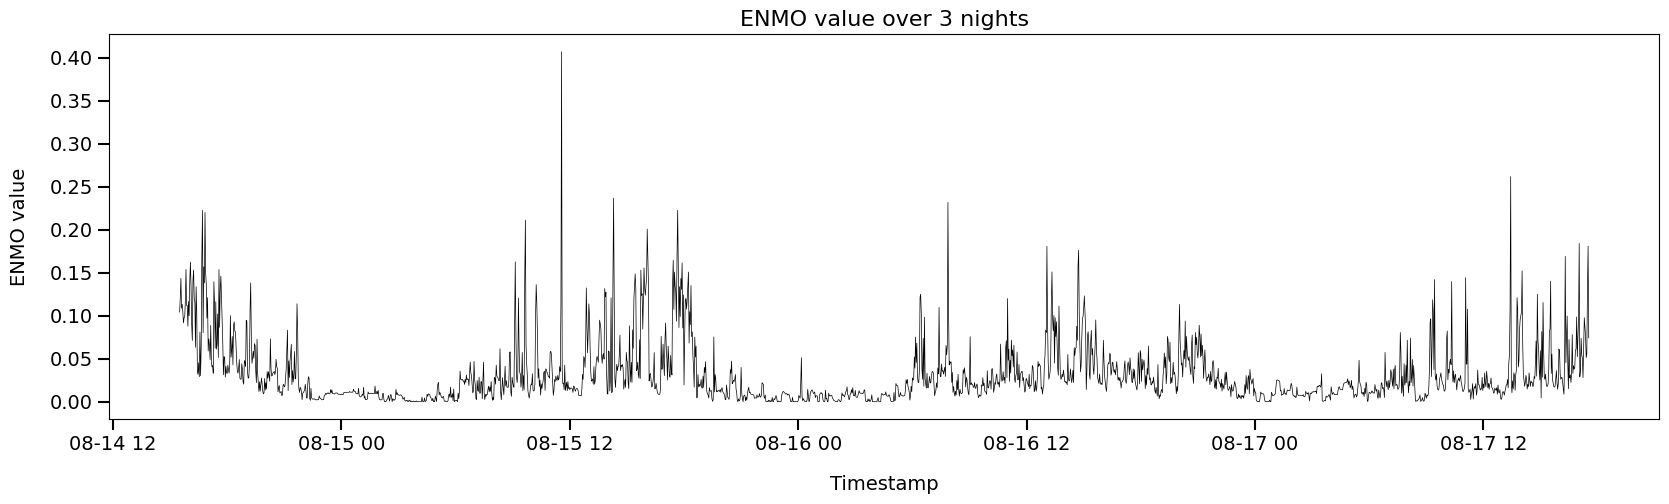

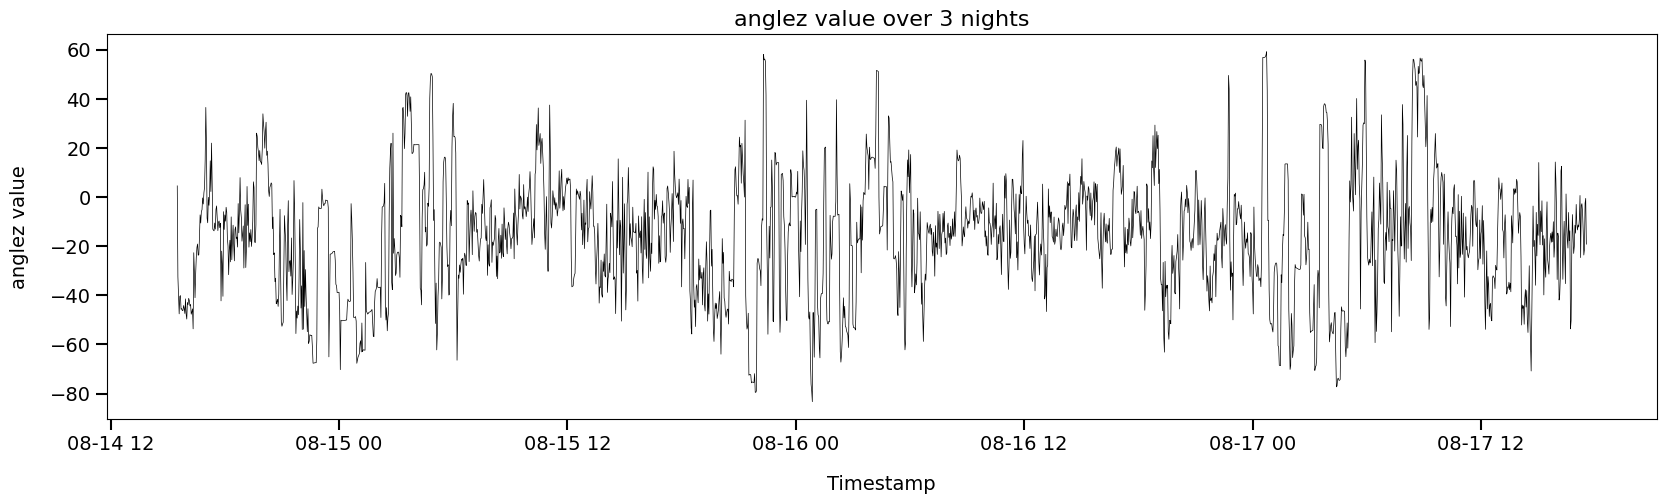

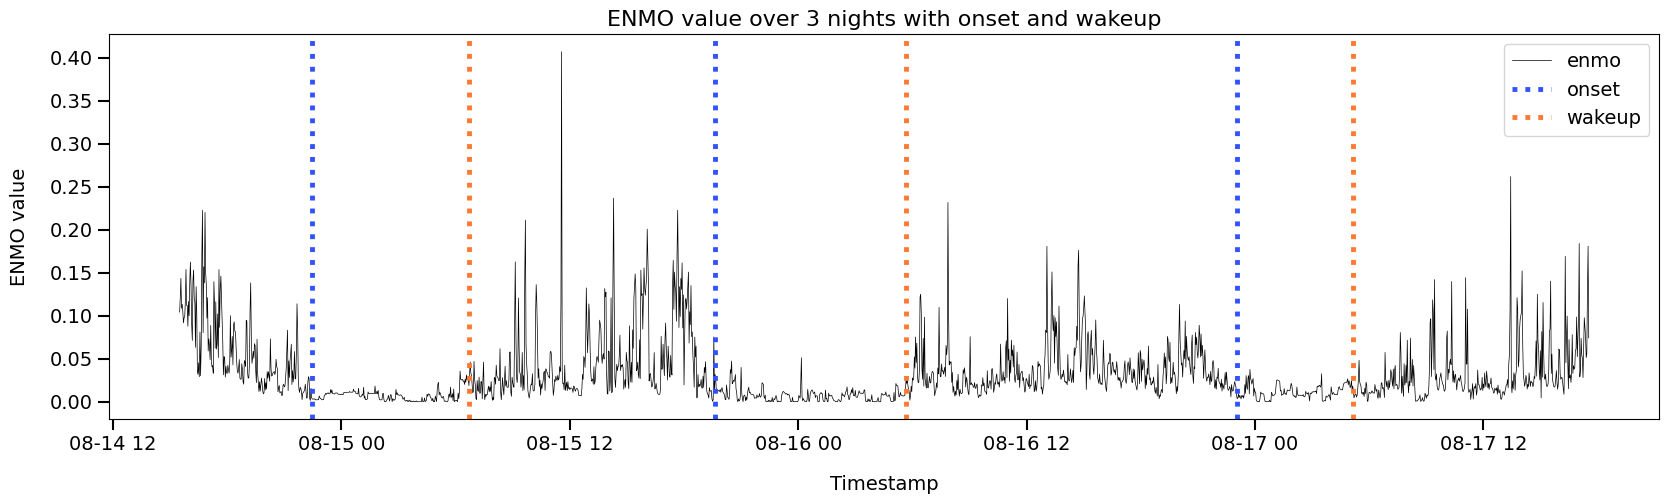

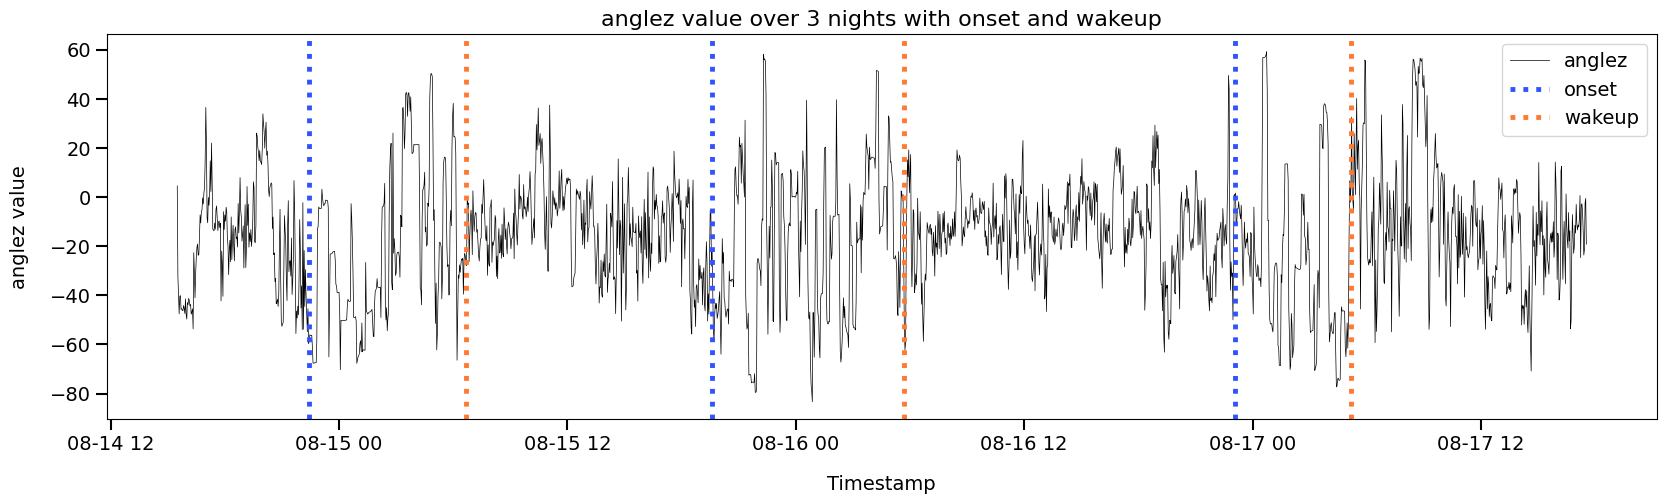

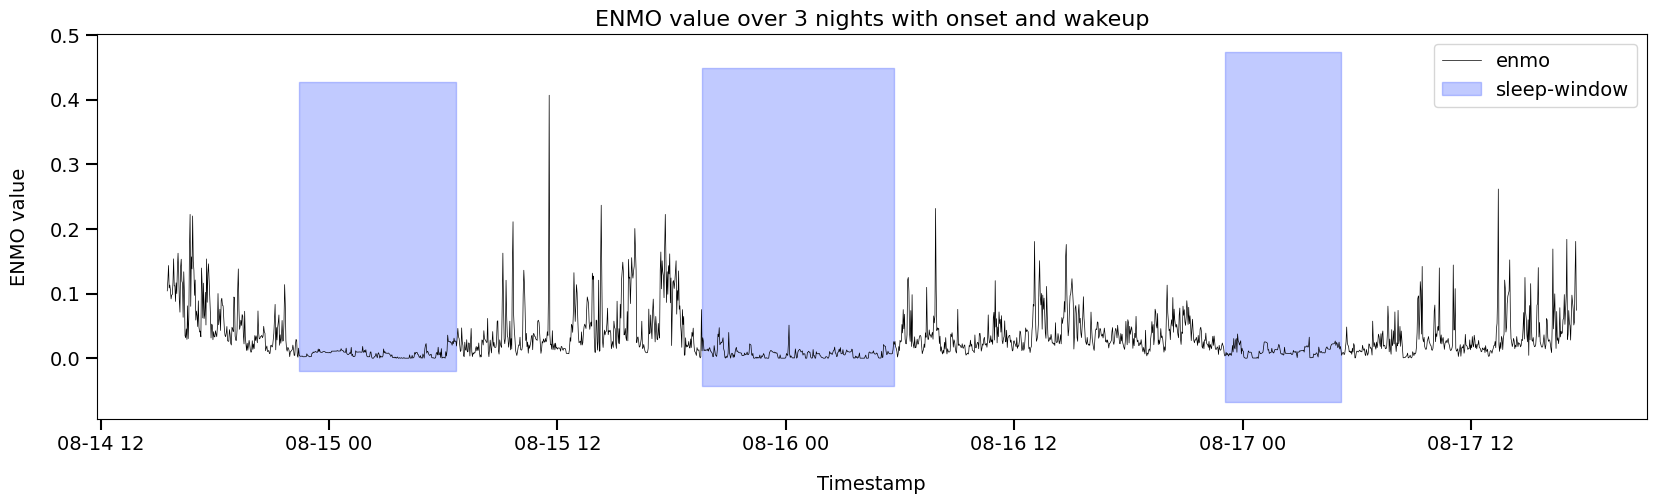

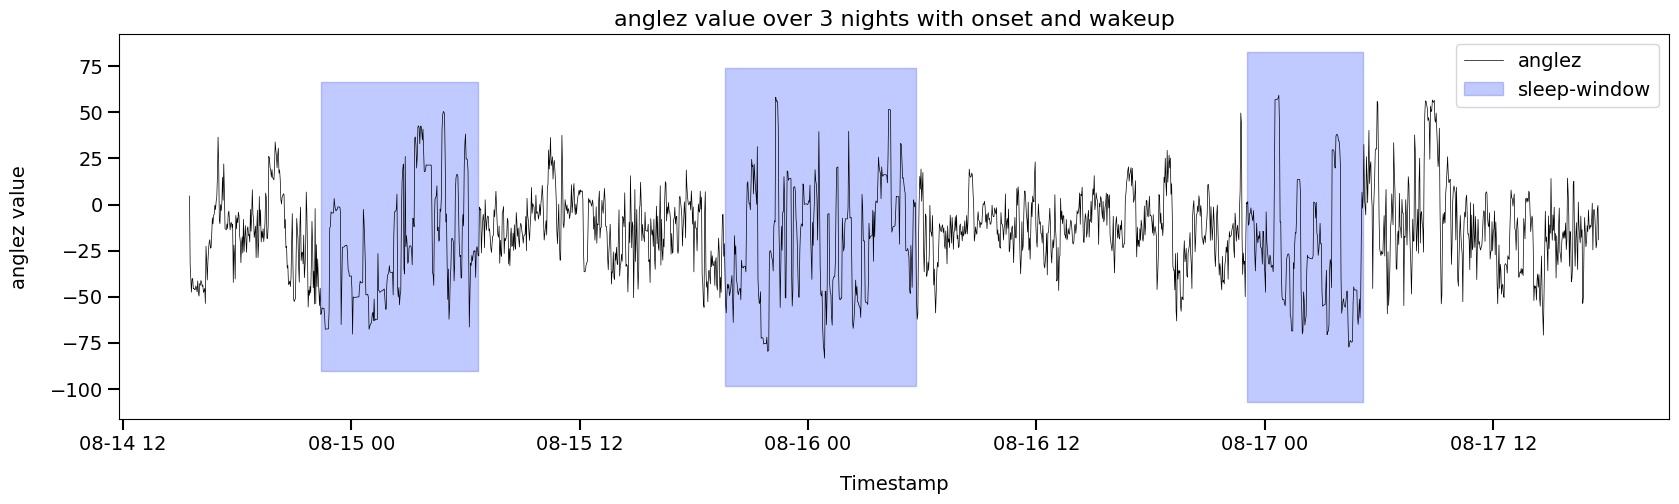

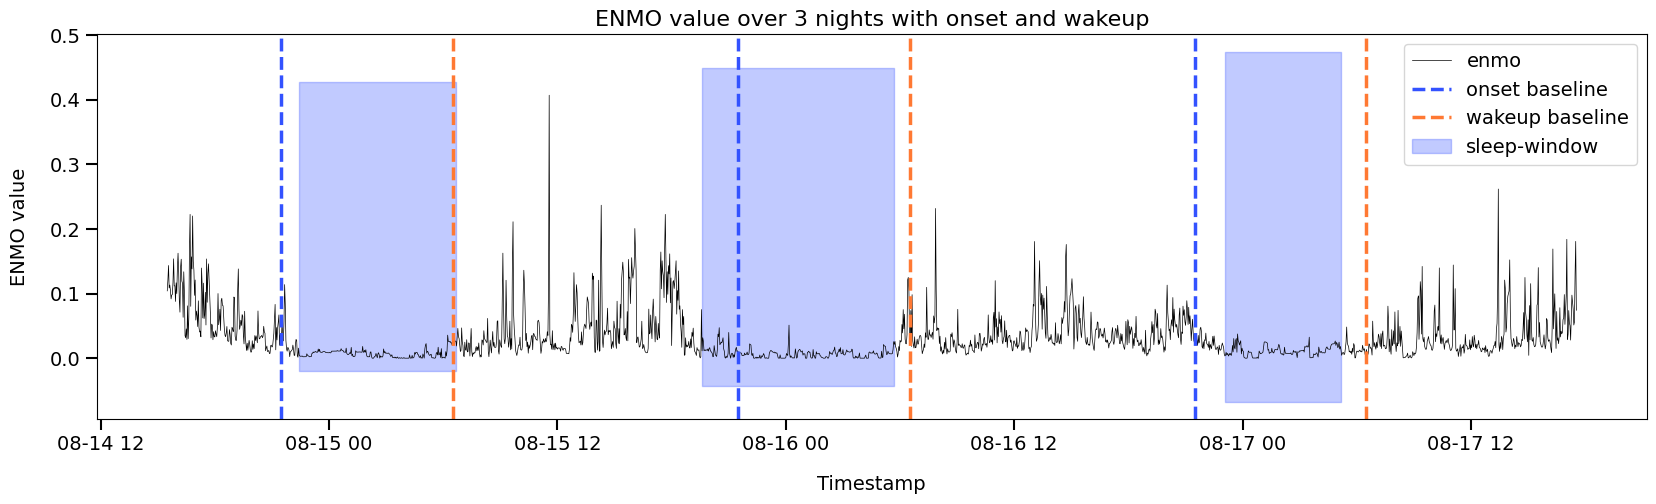

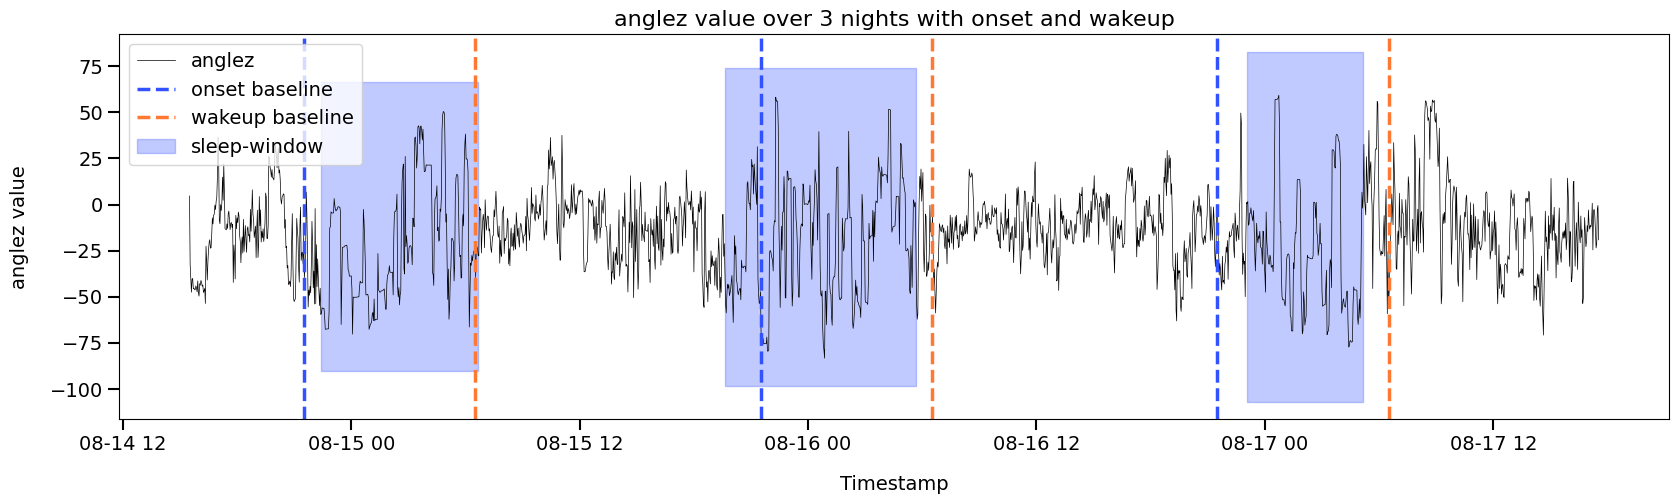

In [128]:
plot_series_with_events(series_ids, subset_series, subset_events)

In [150]:
subset_series.head()

,anglez,enmo,series_id,step
timestamp,,,,
2017-08-04 17:30:00,-41.272293,0.041054,fe90110788d2,0.0
2017-08-04 17:32:00,-5.941275,0.033592,fe90110788d2,24.0
2017-08-04 17:34:00,-5.232609,0.030183,fe90110788d2,48.0
2017-08-04 17:36:00,-14.377004,0.030054,fe90110788d2,72.0
2017-08-04 17:38:00,-36.387196,0.043508,fe90110788d2,96.0


In [138]:
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [ ]:
# getting a subset with only 3 nights from each id
sub_set = train_events.loc[train_events['night'].isin([1,2,3])]
sub_set.head(3)
last_step=sub_set['step'].max()
sub_set_train_series = train_series.loc[train_series['step'] <= last_step]
sub_set_train_series.head()
sub_set_train_series['timestamp'] = pd.to_datetime(sub_set_train_series['timestamp'].str[:19], format='%Y-%m-%dT%H:%M:%S')
sub_set_train_series[sub_set_train_series['step'] == 4992]

# Resample the DataFrame to 1-minute intervals and aggregate the columns
df_resampled = sub_set_train_series.resample('2Min', on='timestamp').agg({
    'anglez': 'mean',
    'enmo': 'mean',
    'series_id': 'first',
    'step': 'first'
})

# Reset the index if needed
df_resampled.reset_index(inplace=True)
plot_series_with_events(sub_set['series_id'].iloc[0], df_resampled, sub_set)

In [ ]:
plot_series_with_events('038441c925bb', df_resampled, sub_set)